### Betfair Historical Data: patterns of hedgeable prices
1. Following `2_betfair_advanced_data_test.ipynb` steps to download historical data
2. Iterating the stream through a list of files to create a dataset containing multiple events and race days


To connect to the Betfair API through betfairlightweight, you must have first set up your API certificates and saved the login details in dictionary format in a file called `api_logins.json` in the project home directory (`/betfair_project`). The following connects and should return `<LoginResource>` if successful.

In [2]:
import betfairlightweight
from betfairlightweight import filters
import pandas as pd
import numpy as np
import os
import datetime
import json
from pathlib import Path, PurePath #To define open and save locations that are cross-compatible between Windows/Linux
from bz2 import BZ2File #To unzip the Betfair data from its downloaded format
import matplotlib.pyplot as plt

project_dir = Path.cwd().parents[1]
logins_dir = project_dir / 'api_logins.json'

with open(logins_dir) as f:
    login_dict =  json.load(f)
    
trading = betfairlightweight.APIClient(username=login_dict['my_username'],
                                       password=login_dict['my_password'],
                                       app_key=login_dict['my_app_key'],
                                       certs=login_dict['certs_path'])

trading.login()

<LoginResource>

To dig into particular dates, countries, race types and market types we use `.get_file_list()`, specifying our filtering parameters. For example, you can see above that within the sub-dictionary for `'marketTypesCollection'` we have `'WIN'`, among others. The following retrieves a list of the event files that match these parameters. We select only data for 01/02/20, for the `'WIN'` market only and in `'GB'`.

In [3]:
file_list = trading.historic.get_file_list(
    "Horse Racing",
    "Advanced Plan",
    from_day=1,
    from_month=2,
    from_year=2020,
    to_day=3,
    to_month=2,
    to_year=2020,
    market_types_collection=["WIN"],
    countries_collection=["GB"],
    file_type_collection=["M"],
)

To downoad a file, `download_file()` is used, where we specify the download location (on Betfair) in `file_path` and the directory to which it is saved in `store_directory`. The filename is kept as is from Betfair. We both download the file and use the command to assign the file's location to the variable `download` so we can use it in subsequent operations. `file_path` below is a list input over which we iterate `.download_file()`.

In [14]:
data_dir = project_dir / 'data' / 'raw' / 'api'

available_files = file_list

downloaded_files = [] #list of directories of each download

for file in available_files:
    download = trading.historic.download_file(file_path = file, store_directory = data_dir)
    print(download)
    downloaded_files.append(download)

print("Download complete.")

C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168130661.bz2
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168096552.bz2
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168136214.bz2
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168133543.bz2
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168130666.bz2
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168096559.bz2
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168136219.bz2
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168130671.bz2
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168133548.bz2
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168096566.bz2
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168136224.bz2
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168133553.bz2
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168130676.bz2
C:\Users\Asus\OneDrive\py

The downloaded file is .json formatted compressed in a bzip2 (.bz2) folder. The following extracts the file where it is downloaded. It is given no file extension, however it remains in .txt format and is readable in any text reader.

In [15]:
extracted_files = []

for file in downloaded_files:
    zipfile = BZ2File(file) # open the file
    data = zipfile.read() # get the decompressed data
    newfilepath = file.split('.bz2')[0] # removing the extension and saving without a filetype
    open(newfilepath, 'wb').write(data) # write an uncompressed file
    extracted_files.append(newfilepath)
    zipfile.close()
    
print(extracted_files)

['C:\\Users\\Asus\\OneDrive\\python\\betfair_project\\data\\raw\\api\\1.168130661', 'C:\\Users\\Asus\\OneDrive\\python\\betfair_project\\data\\raw\\api\\1.168096552', 'C:\\Users\\Asus\\OneDrive\\python\\betfair_project\\data\\raw\\api\\1.168136214', 'C:\\Users\\Asus\\OneDrive\\python\\betfair_project\\data\\raw\\api\\1.168133543', 'C:\\Users\\Asus\\OneDrive\\python\\betfair_project\\data\\raw\\api\\1.168130666', 'C:\\Users\\Asus\\OneDrive\\python\\betfair_project\\data\\raw\\api\\1.168096559', 'C:\\Users\\Asus\\OneDrive\\python\\betfair_project\\data\\raw\\api\\1.168136219', 'C:\\Users\\Asus\\OneDrive\\python\\betfair_project\\data\\raw\\api\\1.168130671', 'C:\\Users\\Asus\\OneDrive\\python\\betfair_project\\data\\raw\\api\\1.168133548', 'C:\\Users\\Asus\\OneDrive\\python\\betfair_project\\data\\raw\\api\\1.168096566', 'C:\\Users\\Asus\\OneDrive\\python\\betfair_project\\data\\raw\\api\\1.168136224', 'C:\\Users\\Asus\\OneDrive\\python\\betfair_project\\data\\raw\\api\\1.168133553', 'C:

## Using stream listener to read extracted data

We now have a readable raw text file in Betfair's dictionary format. To interpret the data with python, betfairlightweight includes a stream listener which will interpret the input of historical data in the same way that it does for live data. The below is edited from [here](https://github.com/liampauling/betfair/blob/104ff4cb8734038cb9351e74d16dc7bd018111bc/examples/examplestreaminghistorical.py). 

This finds the chosen variables in the data file and outputs them in a .csv format in output.txt. Note: output.txt is ignored by git and is not uploaded into the repository.

In [16]:
from betfairlightweight import StreamListener
from betfairlightweight.streaming.stream import MarketStream

class HistoricalStream(MarketStream):
    # create custom listener and stream

    def __init__(self, listener):
        super(HistoricalStream, self).__init__(listener)

    def on_process(self, market_books):
        for market_book in market_books:
            for runner in market_book.runners:
                time.append(market_book.publish_time)
                marketid.append(float(market_book.market_id))
                inplay.append(market_book.inplay)
                lastpricetraded.append(runner.last_price_traded)
                sp.append(runner.sp.actual_sp)

time = []
marketid = []
inplay = []
lastpricetraded = []
sp = []
        
datadict = {'Time': time, 'MarketId' : marketid, 'Inplay' : inplay, \
    'LastPriceTraded' : lastpricetraded, 'Sp' : sp}

class HistoricalListener(StreamListener):
    def _add_stream(self, unique_id, stream_type):
        if stream_type == "marketSubscription":
            return HistoricalStream(self)
        
listener = HistoricalListener(max_latency=None)

for file in extracted_files:
    stream = trading.streaming.create_historical_stream(
        directory=file,
        listener=listener,
    )
    stream.start() 
    print(str(file) + " stream completed.")
    
print("Stream complete.")

C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168130661 stream completed.
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168096552 stream completed.
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168136214 stream completed.
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168133543 stream completed.
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168130666 stream completed.
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168096559 stream completed.
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168136219 stream completed.
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168130671 stream completed.
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168133548 stream completed.
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168096566 stream completed.
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168136224 stream completed.
C:\Users\Asus\OneDriv

Iterating the Historical Listener through the list of `extracted_files` to create data_dict

We can now view the data:

In [17]:
df = pd.DataFrame(datadict)
df.head()

,Time,MarketId,Inplay,LastPriceTraded,Sp
0,2020-01-31 11:41:45.697,1.168131,False,0.0,NaN
1,2020-01-31 11:41:45.697,1.168131,False,0.0,NaN
2,2020-01-31 11:41:45.697,1.168131,False,0.0,NaN
3,2020-01-31 11:41:45.697,1.168131,False,0.0,NaN
4,2020-01-31 11:41:45.697,1.168131,False,0.0,NaN


In [18]:
df.info

<bound method DataFrame.info of                            Time  MarketId  Inplay  LastPriceTraded      Sp
0       2020-01-31 11:41:45.697  1.168131   False             0.00     NaN
1       2020-01-31 11:41:45.697  1.168131   False             0.00     NaN
2       2020-01-31 11:41:45.697  1.168131   False             0.00     NaN
3       2020-01-31 11:41:45.697  1.168131   False             0.00     NaN
4       2020-01-31 11:41:45.697  1.168131   False             0.00     NaN
...                         ...       ...     ...              ...     ...
7615456 2020-02-03 20:36:10.477  1.168255    True          1000.00   38.00
7615457 2020-02-03 20:36:10.477  1.168255    True          1000.00   27.99
7615458 2020-02-03 20:36:10.477  1.168255    True             1.01    6.20
7615459 2020-02-03 20:36:10.477  1.168255    True          1000.00  381.83
7615460 2020-02-03 20:36:10.477  1.168255    True          1000.00    3.30

[7615461 rows x 5 columns]>

In [25]:
#inplay only
#df = df[df['Inplay'] == True].reset_index(inplace=True)

In [26]:
#Creating a comparable time index, counting time to and from start in seconds with start = 0

%time

# converting to datetime
df['Time'] = pd.to_datetime(df['Time'], format="%Y-%m-%d %H:%M:%S", errors='coerce')

# calculating inplay start for each race (assigning to new columns)
df['start_time'] = df['Time'].where(df['Inplay'] == True).groupby(df['MarketId']).transform('min')

# calculating difference between each time point and start time
df['time_dif'] = (df['Time'] - df['start_time']).astype('timedelta64[s]')

df = df.drop('start_time', 1)
df = df.drop('Time', 1)

Wall time: 0 ns


MemoryError: Unable to allocate 58.1 MiB for an array with shape (7615461,) and data type datetime64[ns]

### Analysis: profitable hedge prices in play
* Creating a boolean for prices that would have made a profitable hedge


In [27]:
def lay_hedge_max_lp(bp, c):
    '''
    Given some back price and commission, this returns the maximum lay price for a profitable hedge bet. The lower the lay price, the more profitable the bet.
    '''
    return (bp - 1) * (1 - c) ** 2 + 1

In [28]:
#Creating a boolean for whether the current price is a profitable hedge vs. SP
df['LayHedgeProfitable'] = df['Sp'].apply(lambda x: lay_hedge_max_lp(x, 0.05))

df['LayHedgeProfitable'] = np.where(df['LastPriceTraded'] < df['LayHedgeProfitable'], True, False)

df.reset_index(inplace=True)

MemoryError: Unable to allocate 58.1 MiB for an array with shape (7615461,) and data type float64

In [ ]:
#What percentage of prices are profitable hedges (True) on average?
df['LayHedgeProfitable'].value_counts(normalize=True)

In [29]:
#Creating a simplified DF look at hedge feasibility over time
# groupby (mean layhedgeprofitable and counts by time_dif)
df_hedge = pd.DataFrame(df.groupby('time_dif').agg({'LayHedgeProfitable': 'mean',
                                                            'index' : 'count'})).reset_index()
# renaming columns
df_hedge.rename(columns={'LayHedgeProfitable' : 'hedgeable_pc', 'index' : 't_observations'}, inplace = True)

In [33]:
df_hedge = df_hedge[df_hedge['time_dif'] < 400]

In [34]:
df_hedge.head()

,time_dif,hedgeable_pc,t_observations
0,0.0,0.067599,429
1,1.0,0.117825,331
2,2.0,0.205047,317
3,3.0,0.195335,343
4,4.0,0.239583,288


Text(0, 0.5, '')

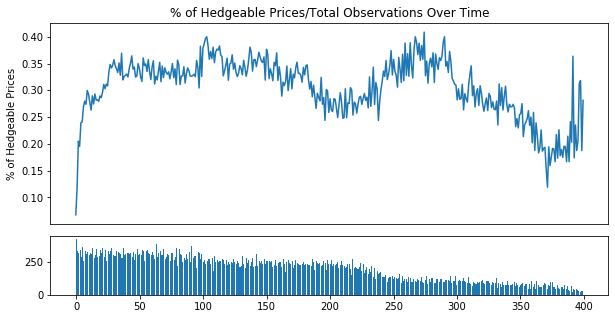

In [35]:
plt.figure(figsize=(10,5))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
top.plot(df_hedge['time_dif'], df_hedge['hedgeable_pc']) 
bottom.bar(df_hedge['time_dif'], df_hedge['t_observations']) 

top.axes.get_xaxis().set_visible(False)
top.set_title('% of Hedgeable Prices/Total Observations Over Time')
top.set_ylabel('% of Hedgeable Prices')
bottom.set_ylabel('Total Observations')
bottom.set_ylabel('')